2024-10-27 22:24:00.629228: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-27 22:24:00.646483: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-27 22:24:00.842431: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-27 22:24:00.845692: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-27 22:24:29.612514: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Dataset shape: (4000, 128, 128, 3), Labels shape: (4000,)


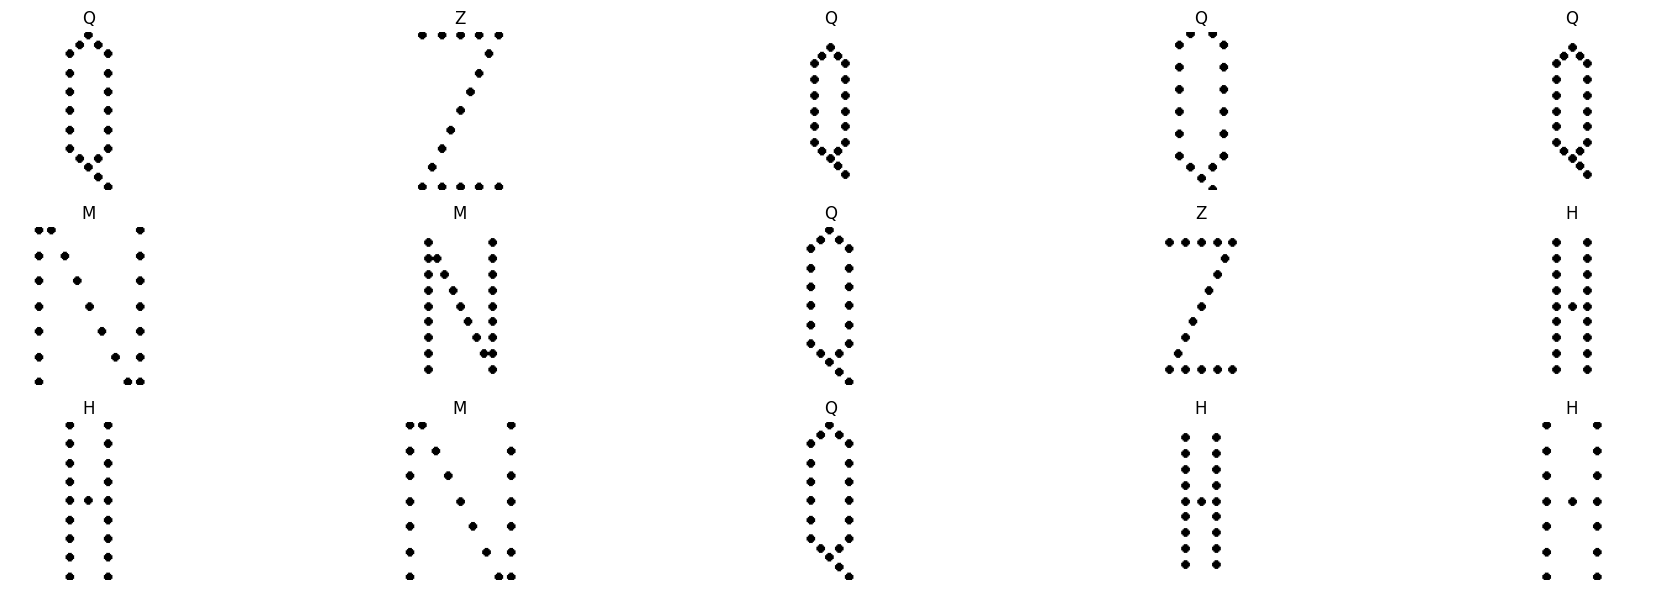

Training set: (3200, 128, 128, 3), (3200, 5)
Testing set: (800, 128, 128, 3), (800, 5)


2024-10-27 22:26:19.240041: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-27 22:26:19.247113: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

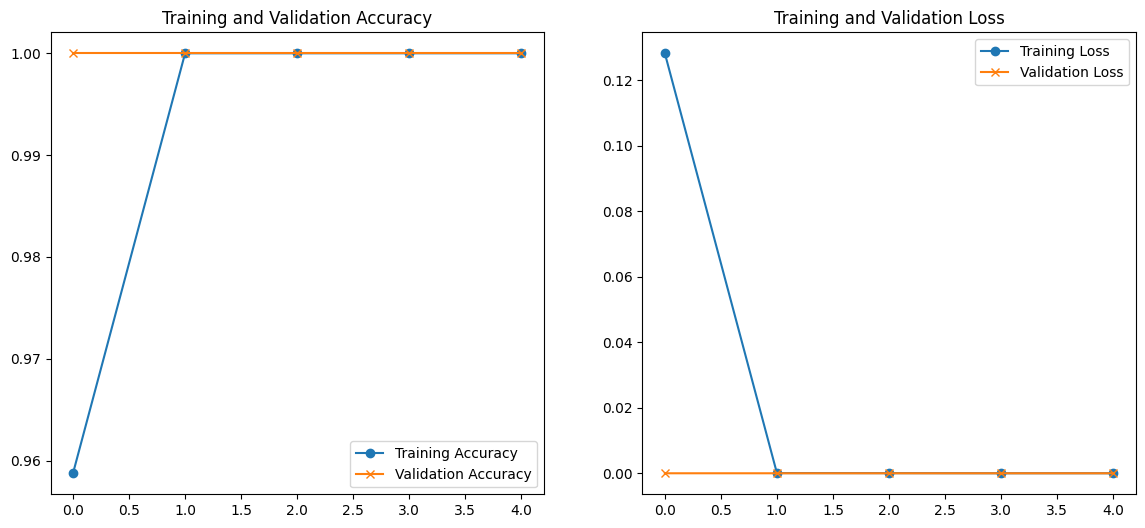


Training with spacing factor: 1.0
Epoch 1/10
13/13 [==============================] - 6s 340ms/step - loss: 1.6101 - accuracy: 0.1950 - val_loss: 1.5979 - val_accuracy: 0.2000
Epoch 2/10
13/13 [==============================] - 4s 306ms/step - loss: 1.5409 - accuracy: 0.3750 - val_loss: 1.3553 - val_accuracy: 1.0000
Epoch 3/10
13/13 [==============================] - 4s 290ms/step - loss: 0.9356 - accuracy: 0.7975 - val_loss: 0.2202 - val_accuracy: 1.0000
Epoch 4/10
13/13 [==============================] - 4s 321ms/step - loss: 0.1403 - accuracy: 0.9725 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 5/10
13/13 [==============================] - 4s 332ms/step - loss: 0.0101 - accuracy: 0.9975 - val_loss: 3.4637e-04 - val_accuracy: 1.0000
Epoch 6/10
13/13 [==============================] - 4s 329ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 3.5666e-04 - val_accuracy: 1.0000
Epoch 7/10
13/13 [==============================] - 5s 361ms/step - loss: 9.7508e-04 - accuracy: 1.0000 -

In [1]:
import os
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

# Configuration Parameters
IMG_SIZE = 128
BG_COLOR = (255, 255, 255)        # White background
MICRO_COLOR = (0, 0, 0)           # Black micro-objects
MICRO_RADIUS = 3
BATCH_SIZE = 32
EPOCHS_INITIAL = 5
EPOCHS_PROGRESSIVE = 10

# Define Macro Shapes with Updated Letters (Replaced 'V' with 'Q')
macro_shapes = {
    'I': [
        # Vertical line
        (0.5, 0.1), (0.5, 0.2), (0.5, 0.3), (0.5, 0.4), (0.5, 0.5),
        (0.5, 0.6), (0.5, 0.7), (0.5, 0.8), (0.5, 0.9),
        # Top and bottom horizontal bars
        (0.45, 0.1), (0.55, 0.1), (0.45, 0.9), (0.55, 0.9)
    ],
    'H': [
        # Left vertical
        (0.4, 0.1), (0.4, 0.2), (0.4, 0.3), (0.4, 0.4), (0.4, 0.5),
        (0.4, 0.6), (0.4, 0.7), (0.4, 0.8), (0.4, 0.9),
        # Right vertical
        (0.6, 0.1), (0.6, 0.2), (0.6, 0.3), (0.6, 0.4), (0.6, 0.5),
        (0.6, 0.6), (0.6, 0.7), (0.6, 0.8), (0.6, 0.9),
        # Middle horizontal bar
        (0.4, 0.5), (0.5, 0.5), (0.6, 0.5)
    ],
    'Q': [
        # Upper semi-circle
        (0.4, 0.2), (0.45, 0.15), (0.5, 0.1), (0.55, 0.15), (0.6, 0.2),
        # Right vertical
        (0.6, 0.3), (0.6, 0.4), (0.6, 0.5), (0.6, 0.6), (0.6, 0.7),
        # Lower semi-circle
        (0.55, 0.75), (0.5, 0.8), (0.45, 0.75), (0.4, 0.7),
        # Left vertical
        (0.4, 0.6), (0.4, 0.5), (0.4, 0.4), (0.4, 0.3),
        # Tail of Q
        (0.55, 0.85), (0.6, 0.9)
    ],
    'Z': [
        # Top horizontal
        (0.2, 0.1), (0.3, 0.1), (0.4, 0.1), (0.5, 0.1), (0.6, 0.1),
        # Diagonal
        (0.6, 0.1), (0.55, 0.2), (0.5, 0.3), (0.45, 0.4), (0.4, 0.5),
        (0.35, 0.6), (0.3, 0.7), (0.25, 0.8), (0.2, 0.9),
        # Bottom horizontal
        (0.2, 0.9), (0.3, 0.9), (0.4, 0.9), (0.5, 0.9), (0.6, 0.9)
    ],
    'M': [
        # Left vertical
        (0.35, 0.1), (0.35, 0.2), (0.35, 0.3), (0.35, 0.4), (0.35, 0.5),
        (0.35, 0.6), (0.35, 0.7), (0.35, 0.8), (0.35, 0.9),
        # Left diagonal
        (0.35, 0.1), (0.4, 0.2), (0.45, 0.3), (0.5, 0.4), (0.55, 0.5),
        # Right diagonal
        (0.55, 0.5), (0.6, 0.6), (0.65, 0.7), (0.7, 0.8), (0.75, 0.9),
        # Right vertical
        (0.75, 0.1), (0.75, 0.2), (0.75, 0.3), (0.75, 0.4), (0.75, 0.5),
        (0.75, 0.6), (0.75, 0.7), (0.75, 0.8), (0.75, 0.9)
    ]
}

label_names = list(macro_shapes.keys())
num_classes = len(label_names)

def create_image(shape_points, spacing_factor=1.0, size=IMG_SIZE, 
                background=BG_COLOR, color=MICRO_COLOR, radius=MICRO_RADIUS):
    """
    Generate an image with micro-objects arranged to form a specified macro-shape.

    :param shape_points: List of (x, y) tuples defining the macro-shape.
    :param spacing_factor: Scaling factor for spacing between micro-objects.
    :param size: Dimension of the square image.
    :param background: Background color.
    :param color: Color of micro-objects.
    :param radius: Radius of each micro-object.
    :return: PIL Image object.
    """
    image = Image.new('RGB', (size, size), background)
    draw = ImageDraw.Draw(image)
    
    # Convert normalized positions to absolute coordinates with spacing
    absolute_coords = []
    for x_norm, y_norm in shape_points:
        abs_x = int(x_norm * size * spacing_factor)
        abs_y = int(y_norm * size * spacing_factor)
        absolute_coords.append((abs_x, abs_y))
    
    # Center the macro-shape
    min_x = min(x for x, y in absolute_coords)
    max_x = max(x for x, y in absolute_coords)
    min_y = min(y for x, y in absolute_coords)
    max_y = max(y for x, y in absolute_coords)
    
    width = max_x - min_x
    height = max_y - min_y
    
    offset_x = (size - width) // 2 - min_x
    offset_y = (size - height) // 2 - min_y
    
    centered_coords = [(x + offset_x, y + offset_y) for (x, y) in absolute_coords]
    
    # Draw micro-objects as circles
    for (x, y) in centered_coords:
        upper_left = (x - radius, y - radius)
        lower_right = (x + radius, y + radius)
        draw.ellipse([upper_left, lower_right], fill=color)
    
    return image

def build_dataset(macro_shapes, labels, samples_per_label=100, 
                 spacing_levels=[1.0, 1.2, 1.4, 1.6], size=IMG_SIZE):
    """
    Create a dataset of images with macro-shapes composed of micro-objects.

    :param macro_shapes: Dictionary of macro-shapes.
    :param labels: List of class labels.
    :param samples_per_label: Number of samples per class per spacing level.
    :param spacing_levels: List of spacing scaling factors.
    :param size: Size of each image.
    :return: Tuple (images, labels)
    """
    img_list = []
    lbl_list = []
    
    for spacing in spacing_levels:
        for cls in labels:
            for _ in range(samples_per_label):
                img = create_image(macro_shapes[cls], spacing, size)
                img_list.append(np.array(img))
                lbl_list.append(labels.index(cls))
    
    img_array = np.array(img_list)
    lbl_array = np.array(lbl_list)
    
    # Normalize image data
    img_array = img_array / 255.0
    
    return img_array, lbl_array

# Generate dataset
images, labels = build_dataset(macro_shapes, label_names, samples_per_label=200, 
                               spacing_levels=[1.0, 1.2, 1.4, 1.6])
print(f"Dataset shape: {images.shape}, Labels shape: {labels.shape}")

def display_samples(imgs, lbls, classes, sample_count=15):
    plt.figure(figsize=(20, 6))
    chosen_indices = np.random.choice(len(imgs), sample_count, replace=False)
    for i, idx in enumerate(chosen_indices):
        plt.subplot(3, 5, i+1)
        plt.imshow(imgs[idx])
        plt.title(classes[lbls[idx]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_samples(images, labels, label_names)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=labels)

# One-hot encode the labels
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print(f"Training set: {X_train.shape}, {y_train_cat.shape}")
print(f"Testing set: {X_test.shape}, {y_test_cat.shape}")

def construct_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=5):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2,2)),
        
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = construct_cnn()
model.summary()

# Train the model
history = model.fit(X_train, y_train_cat, 
                    epochs=5, 
                    batch_size=32, 
                    validation_data=(X_test, y_test_cat))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=2)
print(f"Test accuracy: {test_accuracy*100:.2f}%")

def visualize_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='x')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='x')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    plt.show()

visualize_training(history)

def incremental_training(macro_shapes, labels, start_spacing=1.0, 
                        spacing_step=0.2, total_steps=4, samples_per_label=100, 
                        size=IMG_SIZE):
    model = construct_cnn()
    for step in range(total_steps):
        current_spacing = start_spacing + spacing_step * step
        print(f"\nTraining with spacing factor: {current_spacing}")
        imgs, lbls = build_dataset(macro_shapes, labels, 
                                   samples_per_label=samples_per_label, 
                                   spacing_levels=[current_spacing], 
                                   size=size)
        imgs = imgs / 255.0
        lbls_cat = to_categorical(lbls, num_classes)
        
        # Split into training and validation sets
        X_tr, X_val, y_tr, y_val = train_test_split(imgs, lbls_cat, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=lbls)
        
        # Train the model for a few epochs
        history = model.fit(X_tr, y_tr, 
                            epochs=10, 
                            batch_size=32, 
                            validation_data=(X_val, y_val))
        
        # Evaluate after each step
        val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
        print(f"Validation accuracy after step {step+1}: {val_acc*100:.2f}%")
    
    return model

# Example usage of incremental training:
final_model = incremental_training(macro_shapes, label_names)